# About 



!['directrelief.org'](https://i0.wp.com/www.directrelief.org/wp-content/uploads/2020/01/australia.jpg?w=1800&ssl=1)


<p style='color:green'><b>The 2019–20 Australian bushfire season, colloquially known as the Black Summer, was a period of bushfires in many parts of Australia, which, due to its unusual intensity, size, duration, and uncontrollable dimension, is considered a megafire</b></p>



<p style='color:green'><b>Throughout the summer(summer in autralia is Nov/Dec to Feb), hundreds of fires burnt, mainly in the southeast of the country. The major fires peaked during December–January.</b></p>

<p style='color:green'><b>An Estimated 243,000 to 338,000 SqKm of Land was destroyed, which included about 6000 buildings. The most damage was caused to the wildlife though, and it is estimated that about 3 Billion wild animal perished (mostly reptiles), with some species driven close to extinction.</b></p>

<a href=https://en.wikipedia.org/wiki/2019–20_Australian_bushfire_season#> Source </a>

<h2 style='color:green'> Imports </h2>

In [9]:
!pip install earthengine-api --upgrade -q

In [10]:
!pip freeze | grep earthengine

earthengine-api==0.1.316


In [11]:
import requests
import numpy as np 
import os 
import pickle
import pandas as pd
from collections import defaultdict

import xarray as xrx
import rasterio as rio 
import geopandas as gpd 
from rasterio.mask import mask

import ee 
import matplotlib.pyplot as plt 
import folium
from folium.plugins import DualMap
import branca.colormap as cmp
from scipy import optimize
from IPython import display

<h2 style='color:green'> Authenticating and Initializing Earth Engine </h2>


    This Part is not working as the authentication attempts fail. 

In [12]:
# ee.Authenticate()   #generate a token to authenticate 

In [13]:
# ee.Initialize() #initialize earth engine

<h2 style='color:green'>Some Useful Indices </h2>


    1) Burned Area: Normalized Burn Ratio                            NBR = (NIR - SWIR) / (NIR + SWIR) 
    2) Burn Severity: Differenced Normalized Burn Ratio (dNBR)       dNBR = Prefire_NBR - Postfire_NBR  

<h2 style='color:green'> Get Datasets from Earth Engine </h2>

**Geometry(boundaries)**

In [15]:
'''AUTH Failing

# Get geometry of Aus 
aus_geometry = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Australia'))


#calculate area in consideration
aus_area=ee.Number(aus_geometry.geometry().area()).divide(1e+6).round().getInfo() 

print(f'Total Administrative area of Australia is {aus_area} Sq-Km')
'''


'AUTH Failing\n\n# Get geometry of Aus \naus_geometry = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq(\'ADM0_NAME\', \'Australia\'))\n\n\n#calculate area in consideration\naus_area=ee.Number(aus_geometry.geometry().area()).divide(1e+6).round().getInfo() \n\nprint(f\'Total Administrative area of Australia is {aus_area} Sq-Km\')\n'

# Helper functions 

In [16]:
#plotting 


def add_ee_layer(self, ee_image_object, vis_params, name,opacity=0.75):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      opacity=opacity,
      overlay=True,
      control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# #other 
# def show_layer_on_folium(map_bounds,
#                         layer,
#                         title,
#                         viz_params,
#                         colormap=None,
#                         download=False
#                          opacity=0.90,
#                         basemap= 'OpenStreetMap'):
    
#     #initiate a map
#     map_1=folium.Map(tiles=basemap)
    
#     #fit map to our geometry
#     folium.FitBounds(bounds=map_bounds).add_to(map_1)
    
#     #add ee layer 
#     map_1.add_ee_layer(ee_image_object=layer,
#                        vis_params=viz_params,
#                        name=title,
#                       opacity=opacity)
    
#     #add layer control
#     map_1.add_child(folium.LayerControl())
    
#     if download:
#         map_1.save(f'{title}.html')
#         return None
#     else:
#         return map_1

In [17]:
def plot_hist(arr,
              label,
              ax1=None,
              n_bins=100):
    
    if not ax1:
        ax1=plt.figure(figsize=(16,8))
        
    plt.hist(arr,bins=n_bins)
    plt.title(f'Histogram {label}')
    plt.ylabel('Count')
    plt.xlabel(f'{label}')
    
def plot_monthwise(df,
                  band,
                  ax1=None):
    '''plot seasonal trend in concentration of specified band'''
        
    #mean for each month 
    
    
    ag_df=df.groupby(df.datetime.dt.month).agg({f'{band}':['mean','max','median']}).droplevel(level=0,axis=1)
    ag_df.index.name='Month'
    ag_df.reset_index(inplace=True)
    
    if not ax1:
        ax1=plt.figure(figsize=(16,8))
        
    plt.plot(ag_df['Month'],ag_df['mean'],color='b',label='mean')
#     plt.plot(ag_df['Month'],ag_df['max'],color='r',label='max')
    plt.plot(ag_df['Month'],ag_df['median'],color='k',label='median')
    
    plt.title(f'Monthwise {band}')
    plt.ylabel(f'monthly aggregated {band}')
    plt.xlabel('Month of the year')
    plt.legend()
    plt.show()
    

def plot_datewise(mean_df,
                 band):
    plt.figure(figsize=(16,8))
    plt.plot(mean_df['datetime'],mean_df['mean'],color='b',label='mean')
    plt.plot(mean_df['datetime'],mean_df['median'],color='k',label='median')
    
    plt.title(f'{band} in Aus Region')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(f'{band} (mol/m^2)')
    plt.show()
    

# Important Dates 

In [18]:
Dates = {'Prefire_Start': '2019-01-01',   
         "Prefire_End"   : '2019-08-31',  
         'Fire_Start': '2019-09-01',  # AUG 2019
         'Fire_End': '2020-03-01' ,
         'PostFire_Start': '2020-03-01',
          'PostFire_End': '2020-04-01'
        }    #April 2020


# Part A: Factors Affecting Wildfire risk: 

    Climate Factors: 
    
        Precipitation
        Temperature
        Soil Moisture
        Humidity
        Winds
        
    Geographical Landscape and Vegetation 
        Elevation
        Aspect and Slope 
        Vegetation type and health
        Vegetation density and extent
        Vegetation moisture content.

# Checking Prefire Conditions 

 **As the GEE api does have a limit on computation, I cannot do the analysis here. I have prepared the following rasters with a GEE app called climate Engine.**

**Precipitation(Percent of Average Conditions)**

    The following raster is created using Terraclimate product.The raster in question is from duration Jan 19 to Sept 19,while the historic values for comparison are in the range 1981-2010.

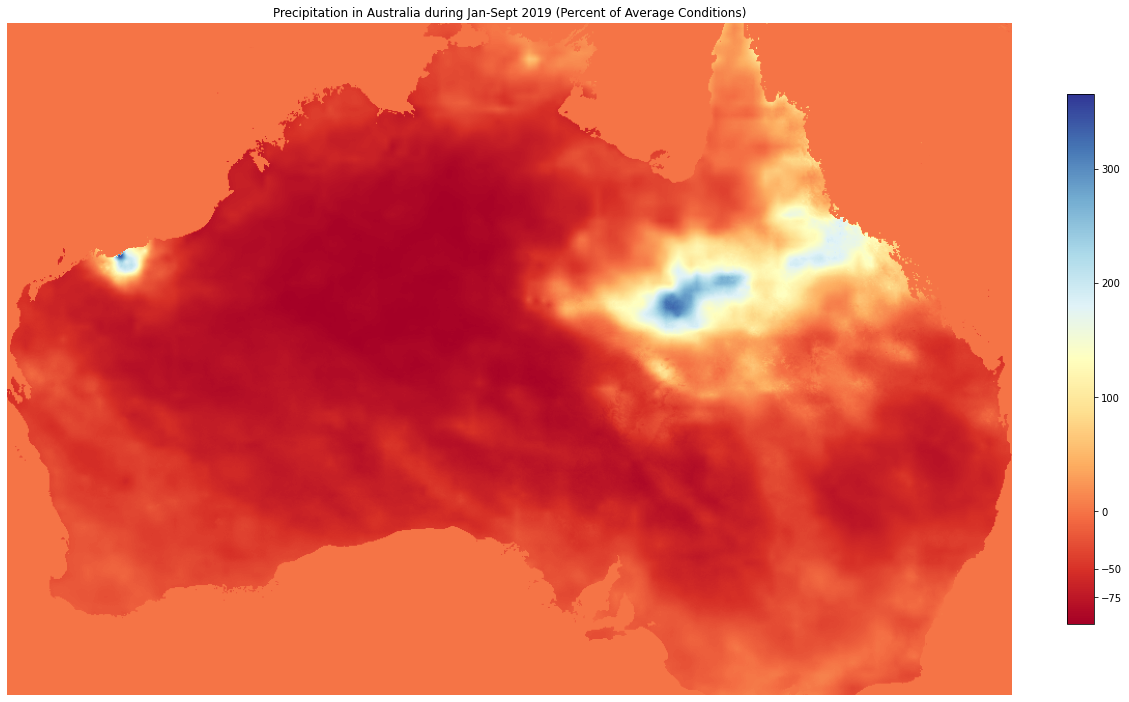

In [19]:
#read precip raster 
precip = rio.open('../input/australia-2020-prefire-monitoring/aus_2019_precip.pr.tif',
                  masked=True)

#get plotting bounds 

precip_bounds = precip.bounds


# scale_raster = lambda x: (x - min(x) ) * 255 /(( max(x) - min(x) ))

pr_arr =precip.read().squeeze(axis=0)

#plot
fig,ax = plt.subplots(figsize=(20,13))
plt.imshow(pr_arr,cmap = 'RdYlBu')
plt.axis('off')
plt.title('Precipitation in Australia during Jan-Sept 2019 (Percent of Average Conditions)')
plt.colorbar(shrink =0.75,fraction=0.05,ticks = [-75,-50,0,100,200,300])
plt.show()

**Soil Moisture(Mean Difference From Average Conditions)**

    The following raster is created using TerraClimate product.The raster in question is from duration Jan 19 to Sept 19,while the historic values for comparison are in the range 1981-2010.

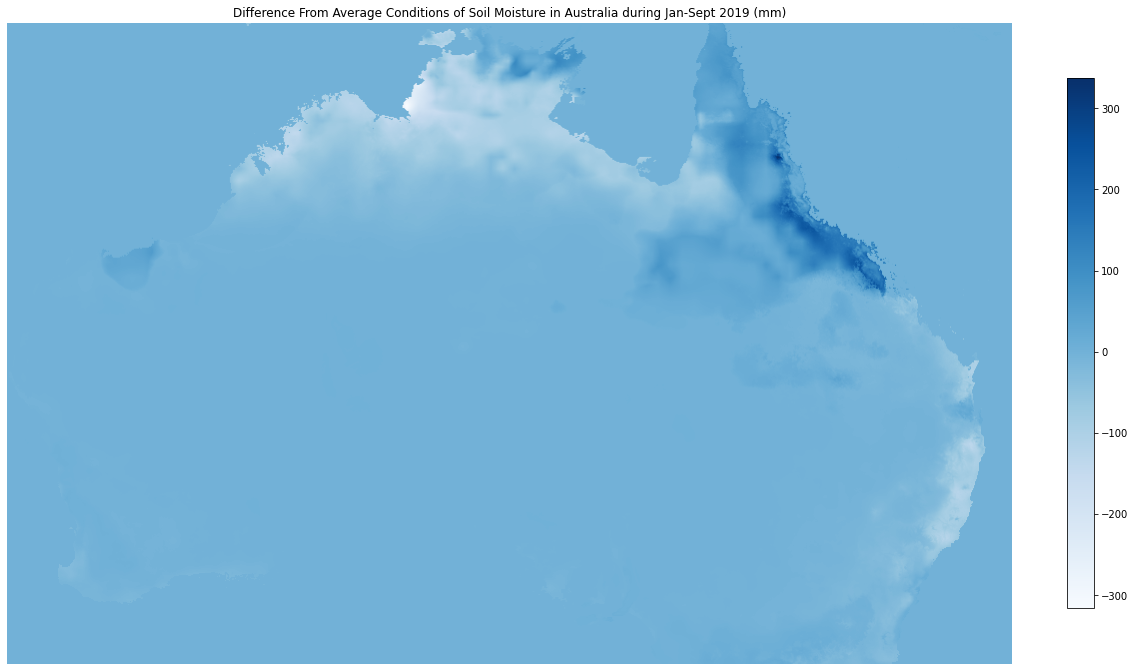

In [20]:
#read precip raster 
sm = rio.open('../input/australia-2020-prefire-monitoring/aus_2019_soil_moisture.tiff.tif',
              nodata=0.0,
              masked=True)


sm_arr =sm.read().squeeze(axis=0)

fig,ax = plt.subplots(figsize=(20,13))
plt.imshow(sm_arr,
           cmap = 'Blues'
          )
plt.axis('off')
plt.title('Difference From Average Conditions of Soil Moisture in Australia during Jan-Sept 2019 (mm)')
plt.colorbar(shrink =0.75,fraction=0.05)
plt.show()

**Max Temperature(Mean Difference From Average Conditions)**

    The following raster is created using TerraClimate product.The raster in question is from duration Jan 19 to Sept 19,while the historic values for comparison are in the range 1981-2010.

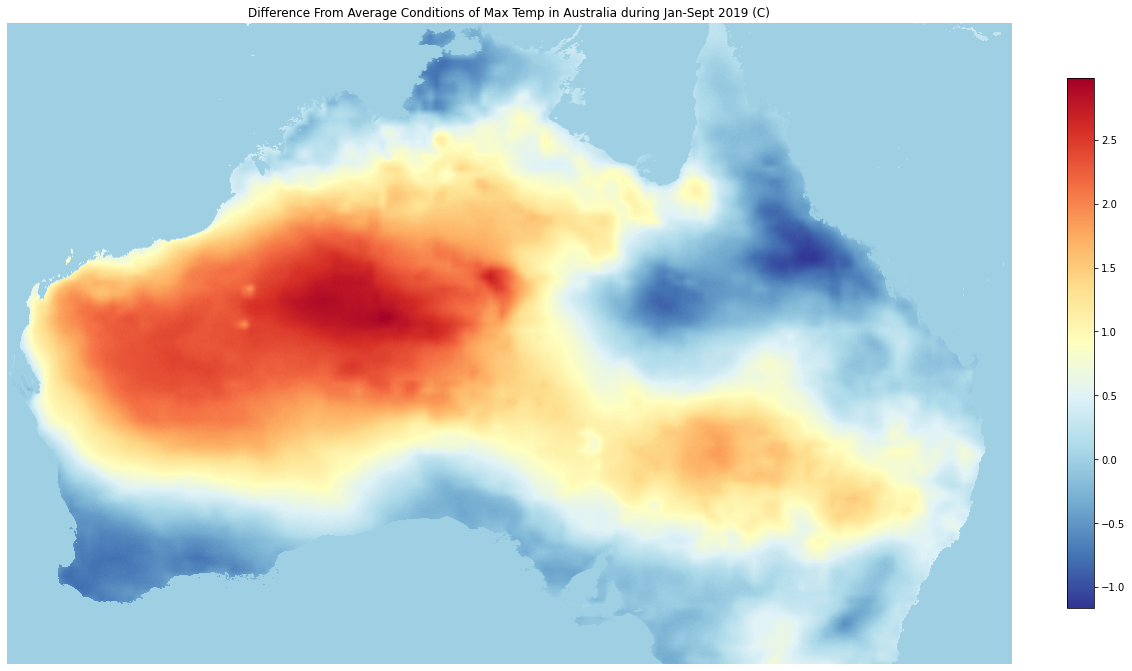

In [21]:
#read raster 
temp = rio.open('../input/australia-2020-prefire-monitoring/aus_2019_max_temp.tmmx.tif',
                  masked=True)


temp_arr =temp.read().squeeze(axis=0)

fig,ax = plt.subplots(figsize=(20,13))
plt.imshow(temp_arr,cmap = 'RdYlBu_r')
plt.axis('off')
plt.title('Difference From Average Conditions of Max Temp in Australia during Jan-Sept 2019 (C)')
plt.colorbar(shrink =0.75,fraction=0.05)
plt.show()

**NDVI(Mean over Jan 2019 to Sept 2019)**

    The following raster is created using Sentinel-2 product.The raster in question is mean ndvi from duration Jan 19 to Sept 19.

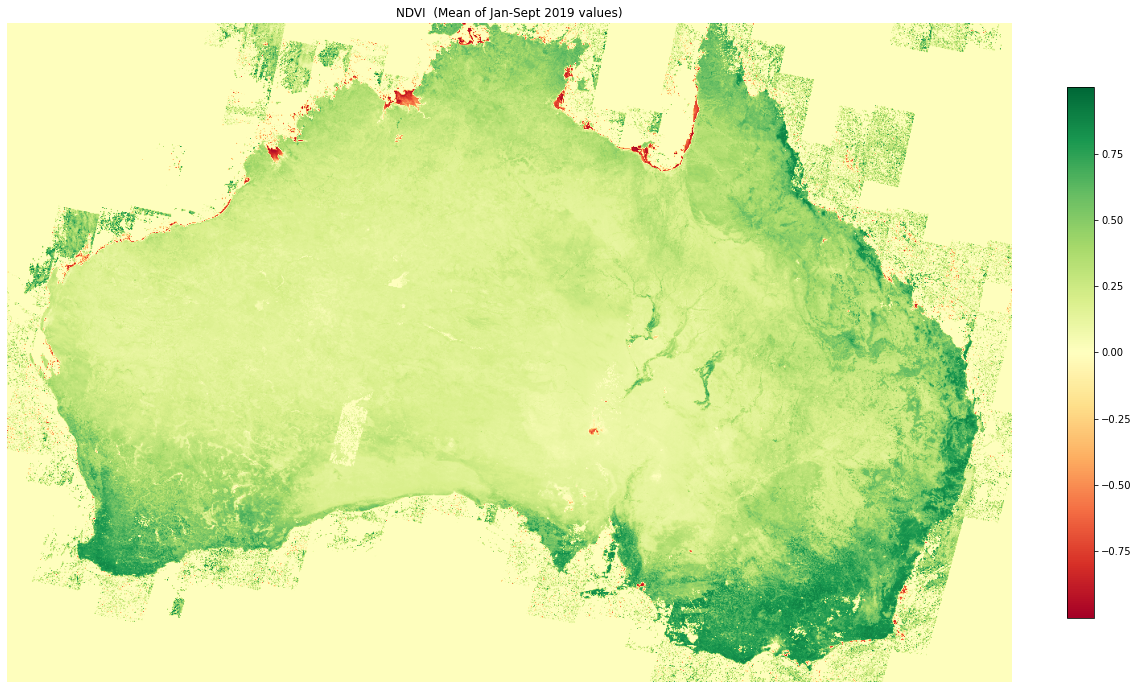

In [22]:

ndvi = rio.open('../input/australia-2020-prefire-monitoring/ndvi_7_9.NDVI.tif',
                  masked=True)


ndvi_arr =ndvi.read().squeeze(axis=0)

fig,ax = plt.subplots(figsize=(20,13))
plt.imshow(ndvi_arr,cmap = 'RdYlGn')
plt.axis('off')
plt.title('NDVI  (Mean of Jan-Sept 2019 values)')
plt.colorbar(shrink =0.75,fraction=0.05)
plt.show()

<h2 style='color:green'> This Part uses the GEE python API, which is giving me problems authenticating right now. The code should work fine once authentication works well. </h2>

# Part C :Postfire Analysis

    Some effects of wildire on the environment are:
    1) Release of C02 and Soot into the atmosphere.
    2) Degradation of soil chemistry and health.
    3) Loss of vegetation, which makes the soil prone to soil erosion and increased runoff.
    4) Destruction of ecosystem and wildlife.

    * Fire intensity:
    The amount of heat or energy released per unit time or area.

    * Burn Severity :
    The effect of a fire on ecosystem properties, often defined by the degree of mortality of vegetation.
    

**Variable to Track**

    * Temperature
    * Precipitation 
    * Vegetation health 
    * Soil Moisture 

**As the area of Australia is very large, I will focus on the area of New South Wales.**

In [ ]:
nsw_geometry = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'New South Wales'))

scale = 5000

# scale and geometry for querying data as a dataset
get_r_params = {'geometry':nsw_geometry.geometry(),
               'scale'     :scale}

area_bounds = [(i[1],i[0]) for i in nsw_geometry.geometry().bounds().getInfo().get('coordinates')[0]]

**Get sentinel image collection**

In [ ]:
S2 = ee.ImageCollection('COPERNICUS/S2').filterBounds(nsw_geometry.geometry())     # copernicus sentinel 2 data 

**Helper functions**

In [ ]:
def s2_cloud_mask(image):
    '''mask sentinel 2 cloud pixels'''
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    
    qa = image.select('QA60')
    mask = qa.bitwise_and(cloudBitMask).eq(0).And(qa.bitwise_and(cirrusBitMask).eq(0))
    
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])



**Apply cloud mask**

In [ ]:
#apply a cloud mask 
S2_cld_msk = S2.map(s2_cloud_mask)

**Creating a Mosiac of prefire and postfire images.**

In [ ]:
#prefire mosiac
pre_fire = S2_cld_msk.filterDate(Dates['Prefire_Start'],Dates['Prefire_End']).sort('CLOUDY_PIXEL_PERCENTAGE',True).sort('filesystem:time_start',False).first()
pre_fire_mos = pre_fire.clip(nsw_geometry)

#postfire 
post_fire = S2_cld_msk.filterDate(Dates['PostFire_Start'],Dates['PostFire_End']).sort('CLOUDY_PIXEL_PERCENTAGE',True).sort('filesystem:time_start',False).first()
pst_fire_mos = post_fire.clip(nsw_geometry)

**NBR & Water - False Positives**

The NBR index can be a powerful tool to identify pixels that have a high likelyhood or being “burned”. However it is important to know that this index is also sensitive to water and thus sometimes, pixels that are classified as “high severity” may actually be water. Because of this, it is important to mask out areas of water PRIOR to performing any quantitative analysis on the difference NBR results.

**Calculating Normalized Burned Ratio (NBR)**

    NBR establishes extent of burned area before and after fire event

    NBR = (NIR - SWIR) / (NIR + SWIR)

In [ ]:
preNBR = pre_fire_mos.normalizedDifference(['B8', 'B12'])
postNBR  = pst_fire_mos.normalizedDifference(['B8', 'B12'])

In [ ]:

download_params = {'scale': 30, # for resolution of image
                    'crs': 'EPSG:4326', # which crs-transformation should apply
                    'region': nsw_geometry.geometry()} # polygon region }

preNBR.getDownloadUrl(download_params)

**Note:  The layer on top of this map will dissapear in a few days. YOu will have to rerun this...**

In [ ]:

image_viz_params = {'min': -1, 'max': 1,
    'palette': ['red','orange','yellow','green','blue']
}
#initiate a dual map
map_1=DualMap(layout='horizontal',min_zoom=8,max_zoom=12)

#fit map to our geometry
folium.FitBounds(bounds=area_bounds).add_to(map_1)

#add ee layer 
map_1.m1.add_ee_layer(ee_image_object=preNBR,
                     vis_params=image_viz_params,
                     name='Pre-NBR(July-Sept 19)',
                     opacity=0.85)


#add ee layer 
map_1.m2.add_ee_layer(ee_image_object=postNBR,
                     vis_params=image_viz_params,
                     name='Post-NBR(Mar-apr 20)',
                     opacity=0.85)

cbar = cmp.StepColormap(
 image_viz_params['palette'],
 vmin=image_viz_params['min'], vmax=image_viz_params['max'],
 caption='Normalized Burn ratio'
)

#add colorbar
cbar.add_to(map_1.m1)


#add layer control
map_1.add_child(folium.LayerControl())
#save 


print('Burnt Area Index (left-prefire,right-postfire)')

map_1

**Calculate Burn Severity: Differenced Normalized Burn Ratio (dNBR)**
    
    dNBR provides a comparison of pre- and post-fire conditions to determine severity
    
    dNBR = Prefire_NBR - Postfire_NBR  

In [ ]:
#get DNBR 
dNBR = preNBR.subtract(postNBR).multiply(1000).rename(['dnbr'])

#Scale product to USGS standards
dNBR = dNBR.multiply(1000)


**Separate result into 8 burn severity classes**

In [ ]:
#thresholds to segment 
thresholds = ee.Image([-1000, -251, -101, 99, 269, 439, 659, 2000])


#segment image into regions
classified = dNBR.lt(thresholds).reduce('sum').toInt()

In [ ]:
palette_clf =['7a8737', 'acbe4d', '0ae042', 'fff70b', 'ffaf38', 'ff641b', 'a41fd6', 'ffffff']

names = ['Enhanced Regrowth, High','Enhanced Regrowth, Low','Unburned', 'Low Severity',
        'Moderate-low Severity', 'Moderate-high Severity', 'High Severity', 'NA']



In [ ]:


map_2=folium.Map()


image_viz_params2 = {'min': -1000, 
                     'max': 1000,
                    'palette': palette_clf}



#fit map to our geometry
folium.FitBounds(bounds=area_bounds).add_to(map_2)

#add ee layer 
map_2.add_ee_layer(ee_image_object=classified,
                     vis_params=image_viz_params2,
                     name='DNBR',
                     opacity=0.85)

cbar = cmp.StepColormap(
 image_viz_params2['palette'],
 vmin=image_viz_params2['min'], 
 vmax=image_viz_params2['max'],
 index = thresholds,
 caption='Difference Normalized Burn ratio (segmented into classes)'
)

#add colorbar
cbar.add_to(map_2)


#add layer control
map_2.add_child(folium.LayerControl())
map_2

# Calculate the burnt area 

In [ ]:


allpix =  classified.updateMask(classified)

# // count pixels in a single class
pixstats = allpix.reduceRegion(**{
                              'reducer': ee.Reducer.count(),               
                              'geometry': nsw_geometry.geometry(),
                              'scale': 30
                              })

allpixels = ee.Number(pixstats.get('sum'))

In [ ]:
#  create an empty list to store area values in
arealist = []



#  create a function to derive extent of one burn severity class
#  arguments are class number and class name
def areacount(cnr, name):
    
    singleMask =  classified.updateMask(classified.eq(cnr))  # mask a single class
    
    stats = singleMask.reduceRegion(
                                    reducer: ee.Reducer.count(),               #count pixels in a single class
                                    geometry: geometry,
                                    scale: 30)
    pix =  ee.Number(stats.get('sum'));
    hect = pix.multiply(900).divide(10000);                
    perc = pix.divide(allpixels).multiply(10000).round().divide(100)   # get area percent by class and round to 2 decimals
    arealist.push({'Class': name, 
                   'Pixels': pix, 
                   'Hectares': hect, 
                   'Percentage': perc})

# severity classes in different order
names2 = ['NA', 'High Severity', 'Moderate-high Severity','Moderate-low Severity', 'Low Severity','Unburned', 'Enhanced Regrowth, Low', 'Enhanced Regrowth, High'];

#  execute function for each class
for i in range(len(names2)):
    areacount(i, names2[i])


**Make a feature collection**

In [ ]:
# // Need to convert the ee.List to an ee.FeatureCollection so it can be exported

def return_feature(element):
    
    return ee.Feature(None,
                      {'Class': element.Class, 
                       'Hectares': element.Hectares, 
                       'Percentage': element.Percentage, 
                       'Pixels': element.Pixels}
                     )

exportable_list = ee.FeatureCollection(arealist.map(return_feature));

print(exportable_list)



**Export feature collection as CSV to drive**

In [ ]:
# Export the burned area stats 'arealist' as a csv
ee.batch.Export.table.toDrive(
    {
  'collection': exportable_list,                  #The feature collection to export
  'folder': 'ARSET_PrePostFireMonitoring',        #The folder in your Google Drive that the csv will reside in
  'description':'Canada_BurnedArea_stats',        #The name of the task for the 'Tasks'-tab
  'fileFormat': 'CSV'                             #A list of properties to include in the export
    });


**Based on NASA Arset Training : https://appliedsciences.nasa.gov/join-mission/training/english/arset-using-earth-observations-pre-and-post-fire-monitoring**

**Other Resources**
* https://docs.astraea.earth/hc/en-us/articles/360049952271-How-to-Create-Interactive-Maps-from-a-RasterFrame
* https://code.earthengine.google.com/bf0e7325fd0c23ff828815adaa8f9eb0
* http://www.pyrogeographer.com/uploads/1/6/4/8/16481944/understanding_mtbs.pdf#:~:text=Just%20like%20with%20NDVI%2C%20the%20NBR%2C%20dNBR%2C%20and,the%20observed%20values%20are%20generally%20-500%20to%201500.
* https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLI-B8/763/2016/isprs-archives-XLI-B8-763-2016.pdf#:~:text=Burn%20severity%20map%20produced%20with%20the%20NBR%20and,HS%2C%2040%25%20MHS%2C%2026%25%20MLS%20and%206%25%20LS.
* http://python-visualization.github.io/folium/quickstart.html#Markers
* https://www.earthdatascience.org/courses/earth-analytics/multispectral-remote-sensing-modis/normalized-burn-index-dNBR/
* https://code.earthengine.google.com/25ade354b78d713f37ec8aa1b9c66952
* https://www.kaggle.com/virajkadam/delhi-air-pollution-visualization/notebook